In [3]:
from datasets import *
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import plotly.express as px

In [4]:
# Treemap degli incassi mensili per anno (2005-2021) con Plotly

# necessario, altrimenti la generazione del colore continuo (e della legenda) dà errore
df = mesi.replace({'Incasso': 0}, 1)

# aggiungo colonna 'Incasso_Totale', da utilizzare poi per generare il colore della treemap
# df['Incasso_Totale'] = np.nan
# for year in range(2005, 2022):
#     sum_y = sum(df[df['Year'] == year]['Incasso'])
#     df.loc[df['Year'] == year, 'Incasso_Totale'] = sum_y

fig = px.treemap(
    df, 
    path=[px.Constant("Totale (2005-2021)"), 'Year', 'Mese'], 
    values='Incasso', 
    color='Incasso',
#     color_continuous_scale=px.colors.sequential.Viridis,
    color_continuous_midpoint=np.average(df['Incasso']),
    maxdepth=2,
    title='Incassi mensili per anno (2005-2021)'
)
fig.update_traces(root_color="lightgrey", hovertemplate='labels=%{label}<br>Incasso_totale=%{value}<extra></extra>')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.update(layout_coloraxis_showscale=False)

# fig.write_html('Dati_Cinema_Italiani/plots/treemap_mesi_depth2.html')

fig.show()

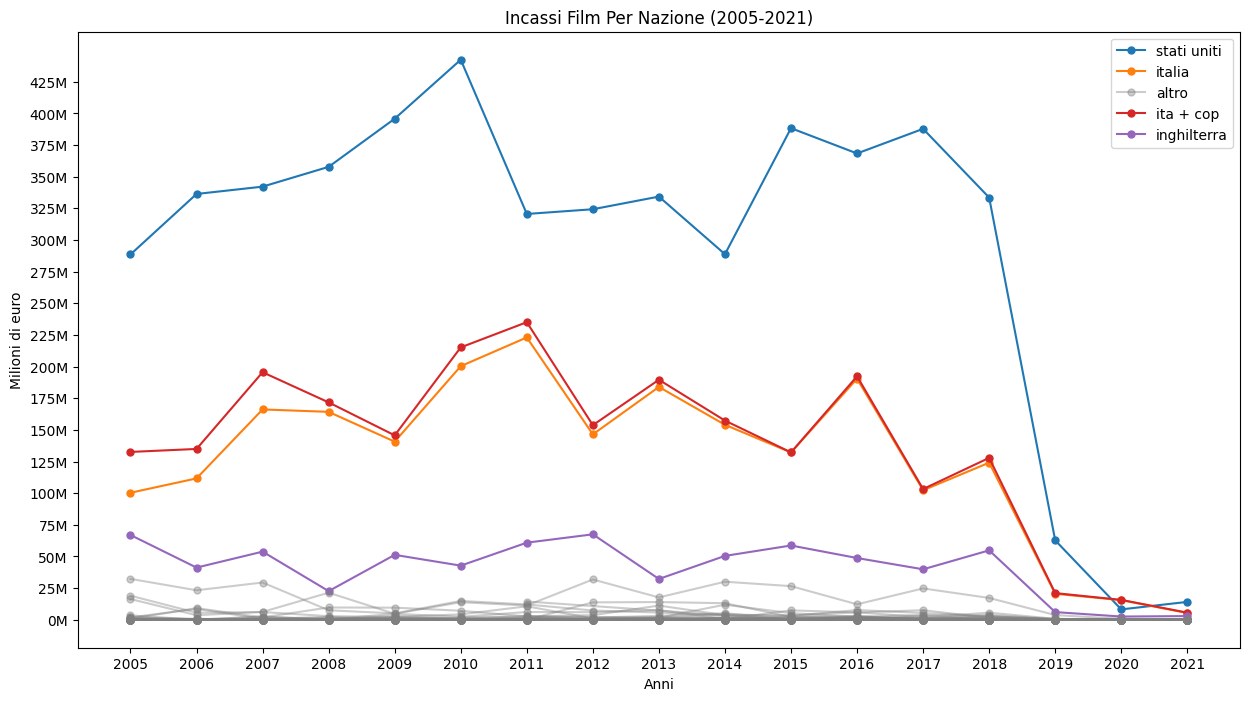

In [5]:
# INCASSI FILM IN ITALIA PER NAZIONE (2005-2021)

# plt.style.use('ggplot')
plt.style.use('default')
fig, ax = plt.subplots(figsize=(15,8))
handles = []

nazioni = naz['Nazione'].unique()

count = 1;
for nazione in nazioni:
    tmp = naz[naz['Nazione'] == str(nazione)][['Year', 'Incasso']]    
    if tmp['Incasso'].max() > 50000000:
        line, = ax.plot(tmp['Year'], tmp['Incasso'], label=nazione.lower(), marker='o', markersize=5)
        handles.append(line)
    else:
        line, = ax.plot(tmp['Year'], tmp['Incasso'], label='altro', alpha=.4, marker='o', markersize=5)
        if count == 1: # mi serve per non aggiungere duplicati nella legenda
            handles.append(line)
            count = 0
        line.set_color('grey')

plt.xlabel('Anni')
plt.ylabel('Milioni di euro')
plt.title('Incassi Film Per Nazione (2005-2021)')

ax.legend(handles = handles)

# custom x_ticks for Million
plt.yticks(np.arange(0, naz['Incasso'].max(), step=25000000))
plt.xticks(np.arange(2005, 2022, step=1))
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:1.0f}M'.format(x*0.000_001) for x in current_values])

plt.savefig('Dati_Cinema_Italiani/plots/Incassi_Nazioni.png', bbox_inches='tight')

plt.show()

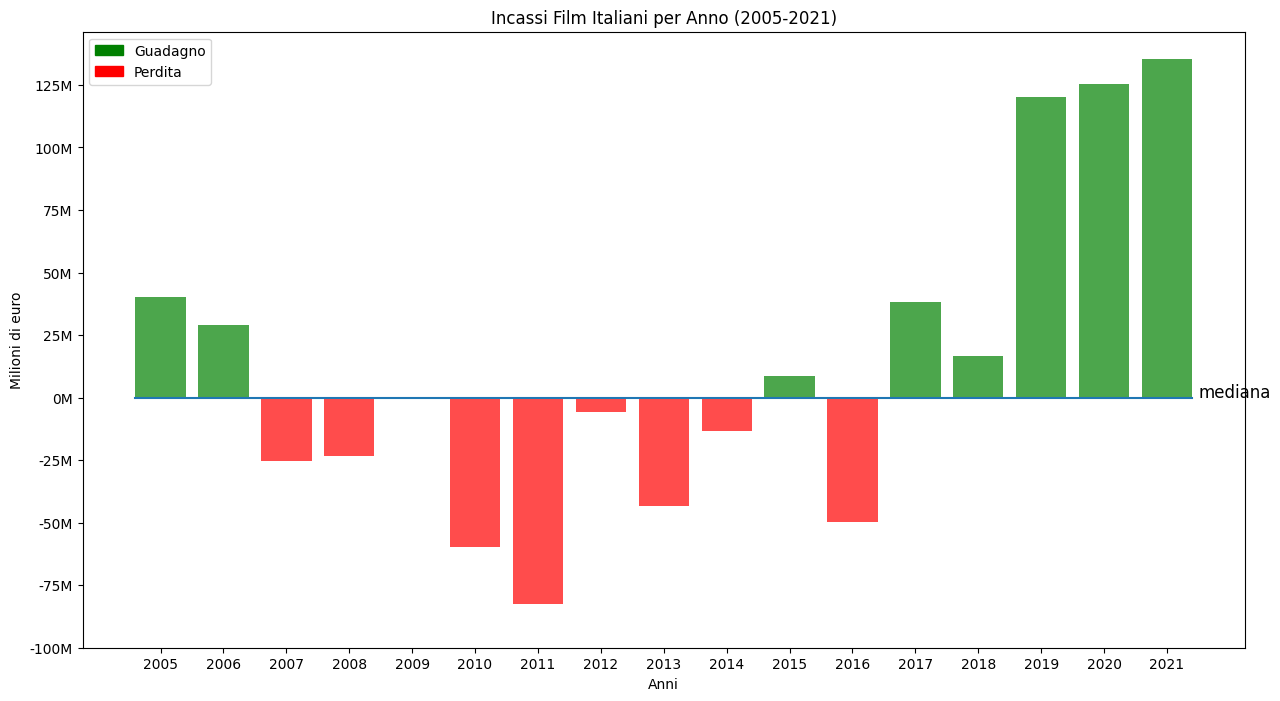

In [6]:
# E ORA UN FOCUS SUL CAMBIAMENTO DEGLI INCASSI DI FILM ITALIANI 2005-2021

def get_changes(df, median):
    incassi = []
    colors = []
    for index, row in df.iterrows():
        change = median-row['Incasso']
        incassi.append(change)
        if change >= 0:
            colors.append('green')
        else:
            colors.append('red')
    return incassi, colors

italia = naz[naz['Nazione'] == 'ITALIA']
incassi, colors = get_changes(italia, italia['Incasso'].median())

c = {'Guadagno':'green', 'Perdita':'red'}      
labels = list(c.keys())
handles = [plt.Rectangle((0,0),1,1, color=c[label]) for label in labels]

fig, ax = plt.subplots(figsize=(15,8))

ax.bar(italia['Year'], incassi, color=colors, label=c, alpha=.7)

plt.xlabel('Anni')
plt.ylabel('Milioni di euro')
plt.title('Incassi Film Italiani per Anno (2005-2021)')
ax.legend(handles, labels)

x = [ax.patches[0].get_x(), ax.patches[-1].get_x() + ax.patches[-1].get_width()]
y = [0 for i in x]
ax.plot(x, y)
ax.text(2021.5, 0, 'mediana', fontsize=12)

plt.yticks(np.arange(-100000000, 150000000, step=25000000))
plt.xticks(np.arange(2005, 2022, step=1))
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:1.0f}M'.format(x*0.000_001) for x in current_values])

plt.savefig('Dati_Cinema_Italiani/plots/Incassi_Italia.png', bbox_inches='tight')

plt.show()

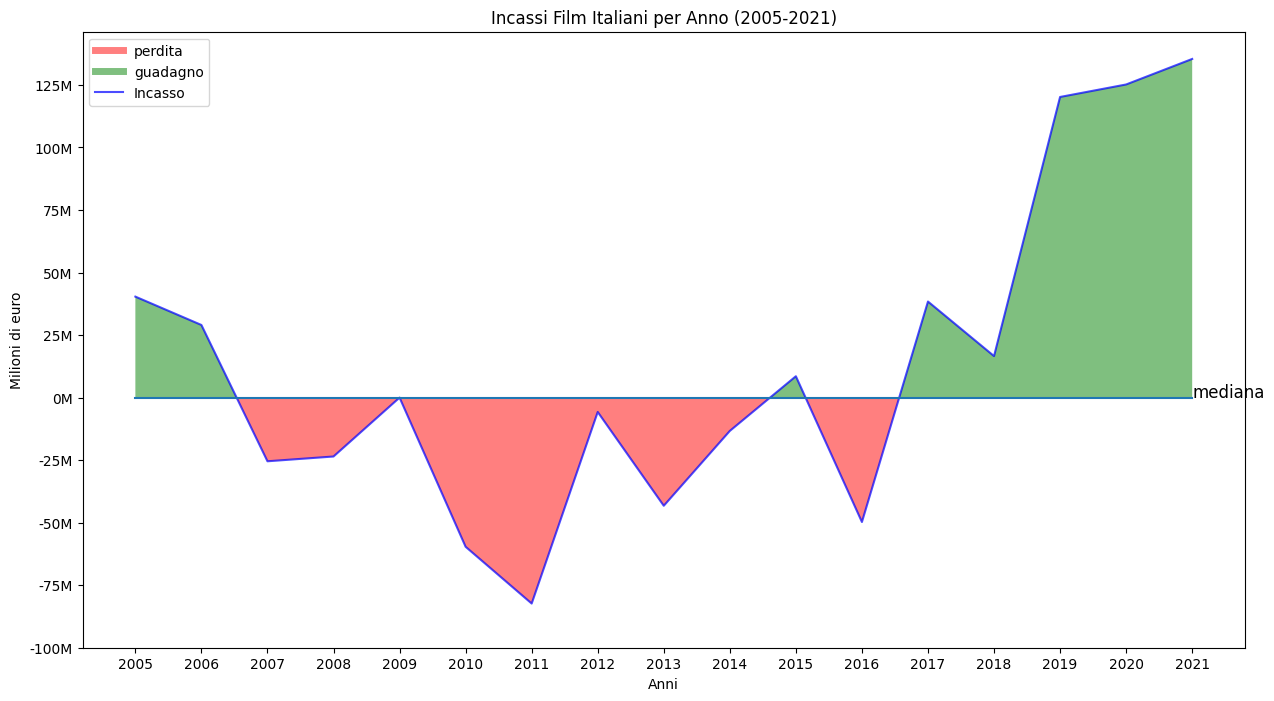

In [7]:
# FOCUS SEMPRE SULL'ITALIA MA CON LINE PLOT E FILL BETWEEN 2005-2021

italia = naz[naz['Nazione'] == 'ITALIA']
median = 0
incassi = pd.Series(incassi)

# necessiario per riempire i "gap" nel fill_between
anni = np.linspace(italia['Year'].iloc[0], italia['Year'].iloc[-1], len(italia['Year']) * 100)
incassi_interp = np.interp(anni, italia['Year'], incassi)

# c = {'Guadagno':'green', 'Perdita':'red'}      
# labels = list(c.keys())
# handles = [plt.Rectangle((0,0),1,1, color=c[label]) for label in labels]

fig, ax = plt.subplots(figsize=(15,8))

# usati per la legenda
ax.plot([],[],linewidth=5, label='perdita', color='r',alpha=0.5)
ax.plot([],[],linewidth=5, label='guadagno', color='g',alpha=0.5)

ax.plot(italia['Year'], incassi, color='blue', label='Incasso', alpha=.7)
ax.fill_between(anni, incassi_interp, median, where=(incassi_interp >= median), facecolor='g', alpha=.5)
ax.fill_between(anni, incassi_interp, median, where=(incassi_interp < median), facecolor='r', alpha=.5)

plt.xlabel('Anni')
plt.ylabel('Milioni di euro')
plt.title('Incassi Film Italiani per Anno (2005-2021)')
ax.legend()

x = italia['Year']
y = [0 for i in x]
ax.plot(x, y, label='mediana')
ax.text(2021, 0, 'mediana', fontsize=12)

plt.yticks(np.arange(-100000000, 150000000, step=25000000))
plt.xticks(np.arange(2005, 2022, step=1))
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:1.0f}M'.format(x*0.000_001) for x in current_values])

plt.savefig('Dati_Cinema_Italiani/plots/Incassi_Italia_fill_between.png', bbox_inches='tight')

plt.show()

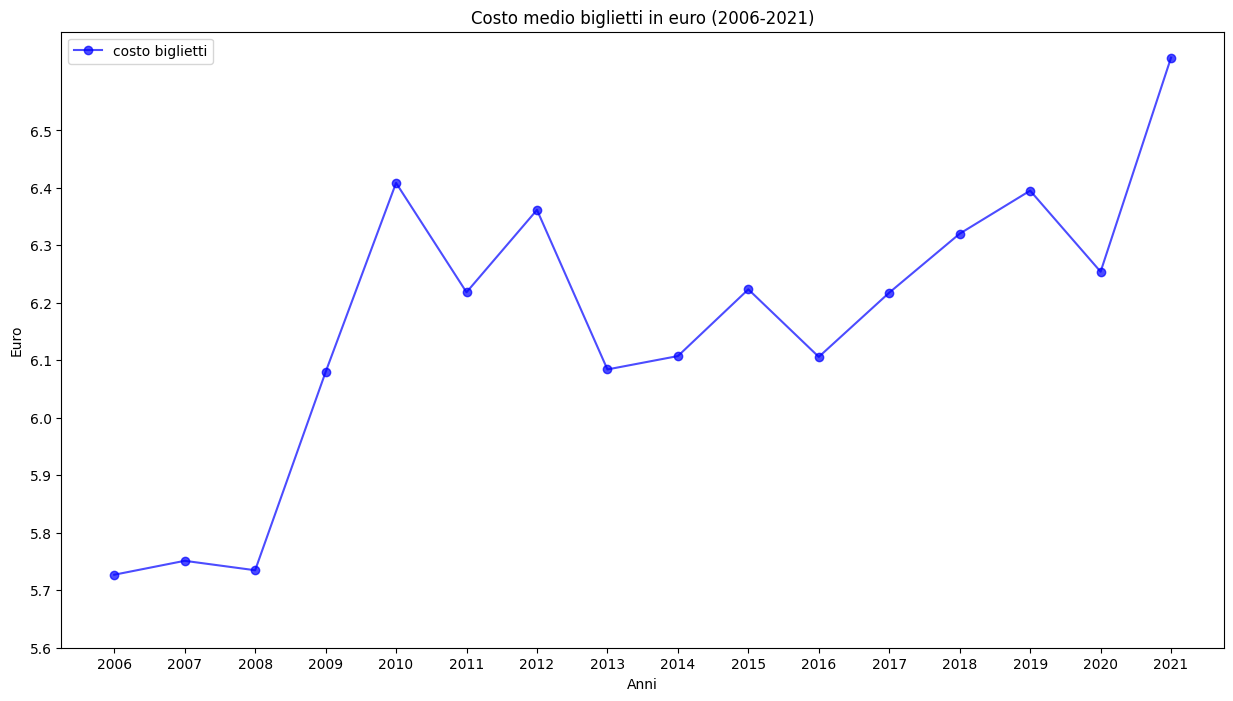

In [8]:
# COSTO MEDIO BIGLIETTI 2006-2021

cb = costo_biglietti.loc[:, '2021':]
tmp = np.arange(2006, 2022)
years = [str(x) for x in tmp]
cb = cb[years]

fig, ax = plt.subplots(figsize=(15,8))

x = cb.columns
y = cb.iloc[0]
ax.plot(x, y, color='blue', label='costo biglietti', alpha=.7, marker='o')

plt.xlabel('Anni')
plt.ylabel('Euro')
plt.title('Costo medio biglietti in euro (2006-2021)')
ax.legend(loc='upper left')

plt.yticks(np.arange(5.6, 6.6, step=.1))

plt.savefig('Dati_Cinema_Italiani/plots/Costo_biglietti.png', bbox_inches='tight')

plt.show()

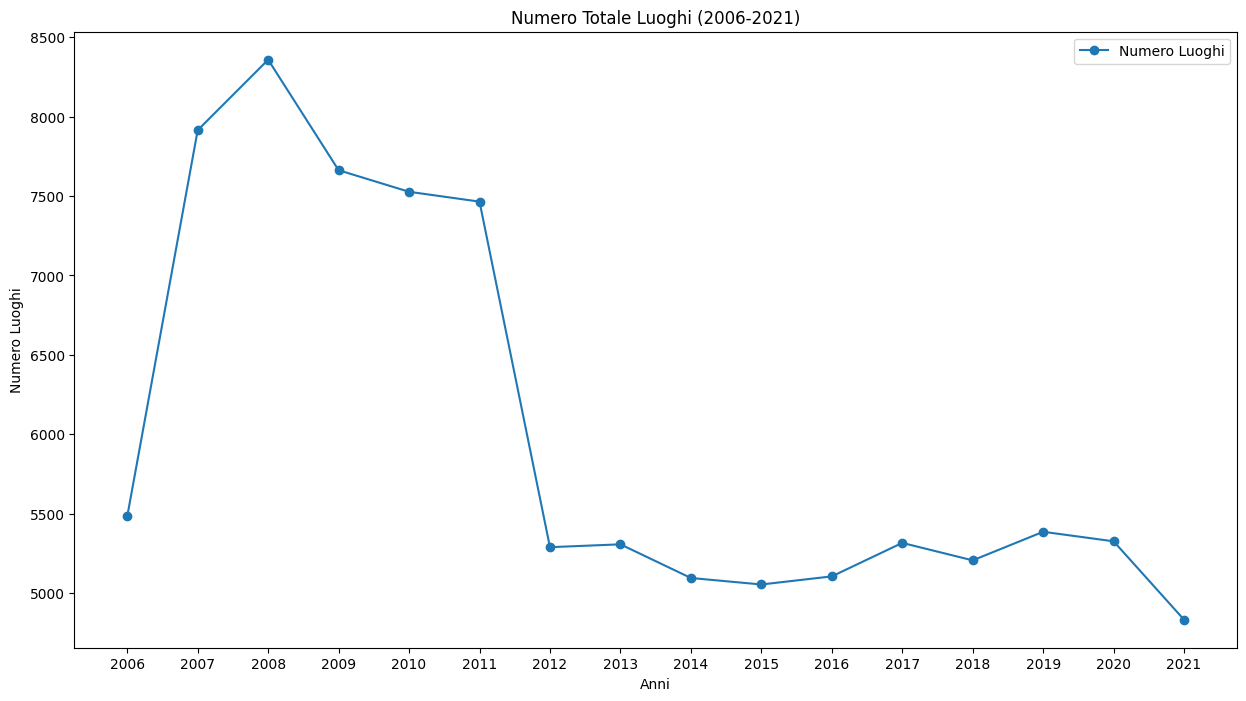

In [9]:
# NUMERO LUOGHI CINEMA IN ITALIA PER REGIONE 2005-2021

fig, ax = plt.subplots(figsize=(15, 8))

x = num_luoghi['Anno']
y = num_luoghi['Totale']

ax.plot(x, y, label='Numero Luoghi', marker='o')

plt.title('Numero Totale Luoghi (2006-2021)')
plt.xlabel('Anni')
plt.ylabel('Numero Luoghi')
ax.legend()

plt.xticks(np.arange(2006, 2022, step=1))

plt.savefig('Dati_Cinema_Italiani/plots/num_luoghi_totale.png', bbox_inches='tight')

plt.show()

In [34]:
lst = []
for year in range(2005, 2022):
    for i in range(0, 10):
            lst.append(box_offices[box_offices['Year'] == year].iloc[i])
top10s = pd.DataFrame(lst)

countbynaz = top10s.groupby(['Year', 'Naz.']).size().to_frame(name='count').reset_index()
x = countbynaz['Year'].unique()
itas = countbynaz[countbynaz['Naz.'] == 'ITA']
itas = pd.concat([itas, pd.DataFrame.from_records([{'Year':2018, 'Naz.':'ITA', 'count':0}])])
itas = itas.sort_values(by=['Year'])['count']
usas = countbynaz[countbynaz['Naz.'] == 'USA']['count']

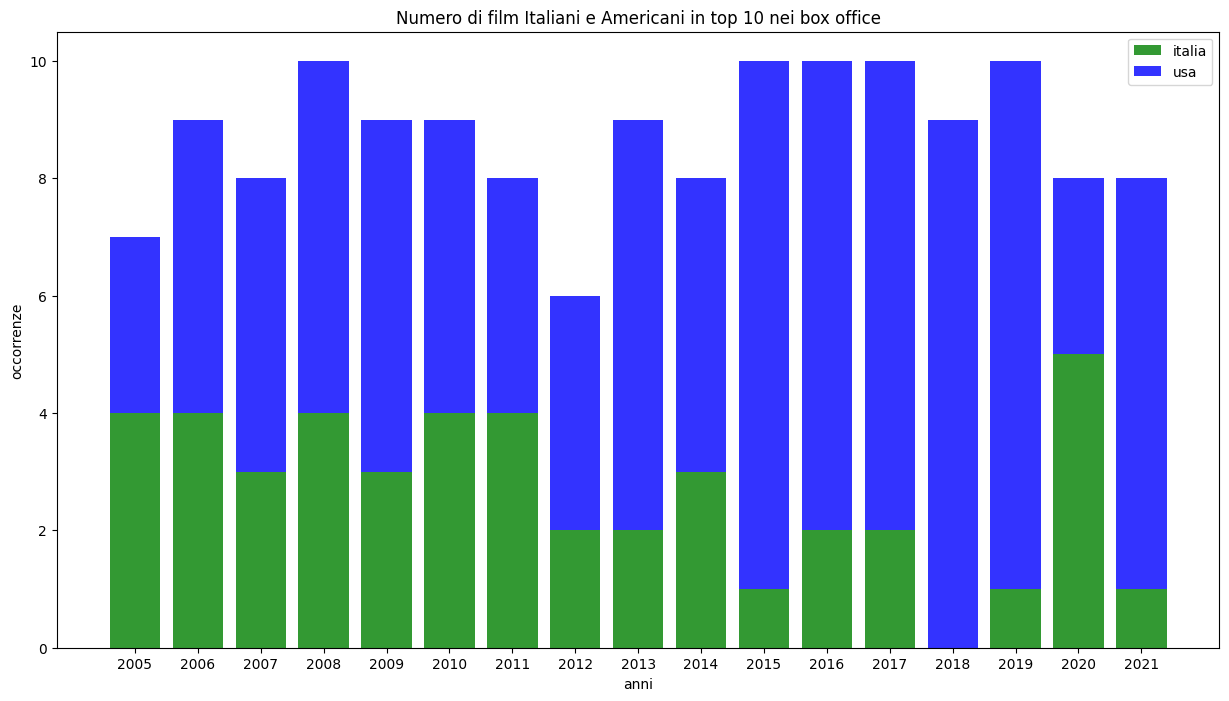

In [20]:
# Film italiani e americani in TOP10

fig, ax = plt.subplots(figsize=(15,8))

ax.bar(x, itas, color='green', label='italia', alpha=.8)
ax.bar(x, usas, color='blue', bottom=itas, label='usa', alpha=.8)

plt.xticks(range(2005, 2022))
plt.ylabel('occorrenze')
plt.xlabel('anni')
plt.title('Numero di film Italiani e Americani in top 10 nei box office')
plt.legend()

plt.savefig('Dati_Cinema_Italiani/plots/Ita_Usa_occ_top10.png', bbox_inches='tight')

plt.show()

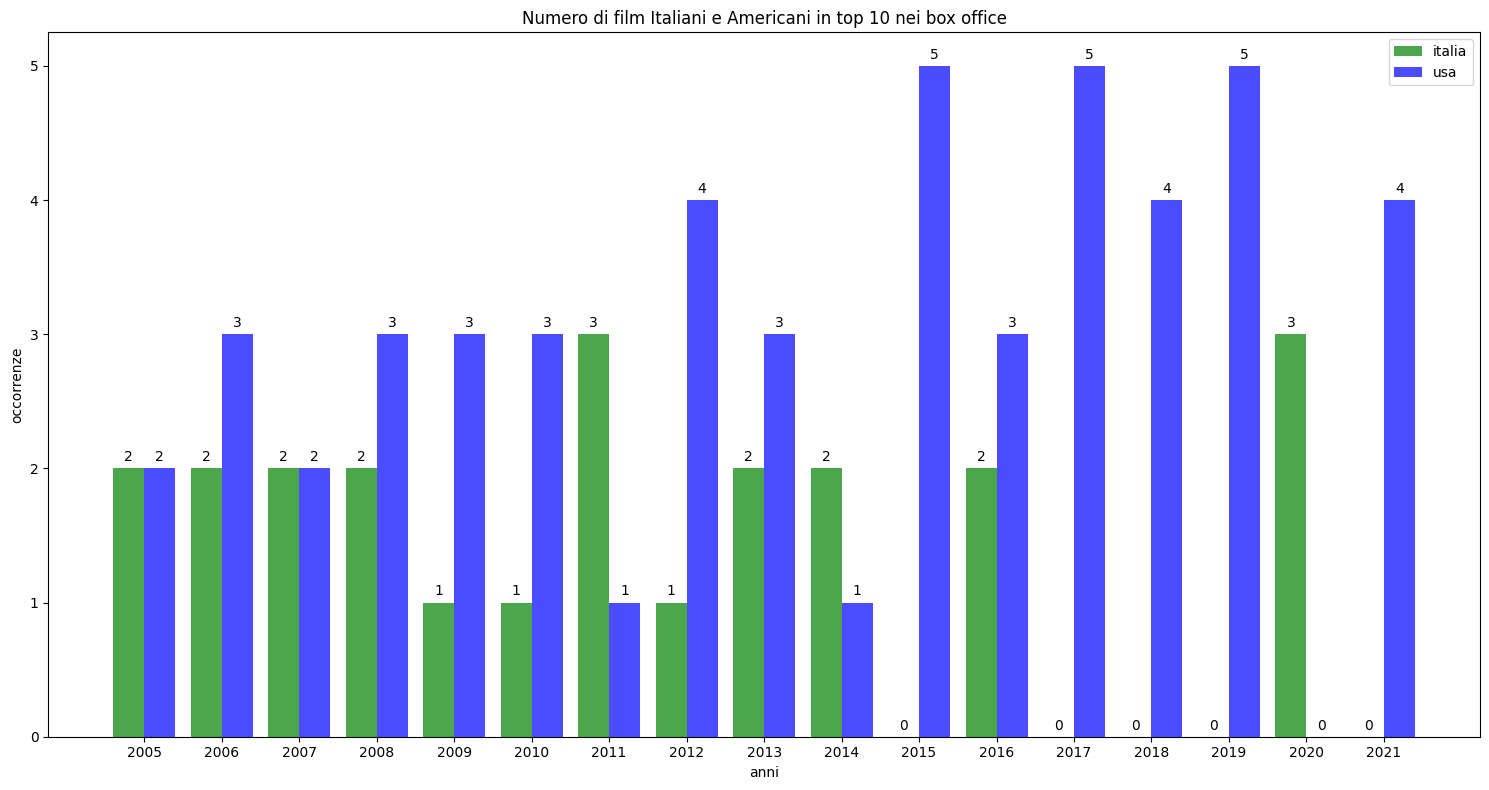

In [100]:
# Film italiani e americani in TOP10

labels = np.arange(2005, 2022)
x = np.arange(len(itas))

fig, ax = plt.subplots(figsize=(15,8))

width = 0.4

rects1 = ax.bar(x - width/2, itas, width=width, color='green', label='italia', alpha=.7)
rects2 = ax.bar(x + width/2, usas, width=width, color='blue', label='usa', alpha=.7)

ax.set_ylabel('occorrenze')
ax.set_xlabel('anni')
ax.set_title('Numero di film Italiani e Americani in top 10 nei box office')
ax.set_xticks(x, labels)
plt.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.savefig('Dati_Cinema_Italiani/plots/Ita_Usa_occ_top10_groupbarchart.png', bbox_inches='tight')

plt.show()

In [90]:
lst = []
for year in range(2005, 2022):
    for i in range(0, 5):
            lst.append(box_offices[box_offices['Year'] == year].iloc[i])
top5s = pd.DataFrame(lst)

countbynaz = top5s.groupby(['Year', 'Naz.']).size().to_frame(name='count').reset_index()
x = countbynaz['Year'].unique()
itas = countbynaz[countbynaz['Naz.'] == 'ITA']
usas = countbynaz[countbynaz['Naz.'] == 'USA']

ita_years = countbynaz[countbynaz['Naz.'] == 'ITA']['Year'].tolist()
for year in range(2005, 2022):
    if year not in ita_years:
        itas = pd.concat([itas, pd.DataFrame.from_records([{'Year':year, 'Naz.':'ITA', 'count':0}])])

usa_years = countbynaz[countbynaz['Naz.'] == 'USA']['Year'].tolist()
for year in range(2005, 2022):
    if year not in usa_years:
        usas = pd.concat([usas, pd.DataFrame.from_records([{'Year':year, 'Naz.':'USA', 'count':0}])])

itas = itas.sort_values(by=['Year'])['count']
usas = usas.sort_values(by=['Year'])['count']

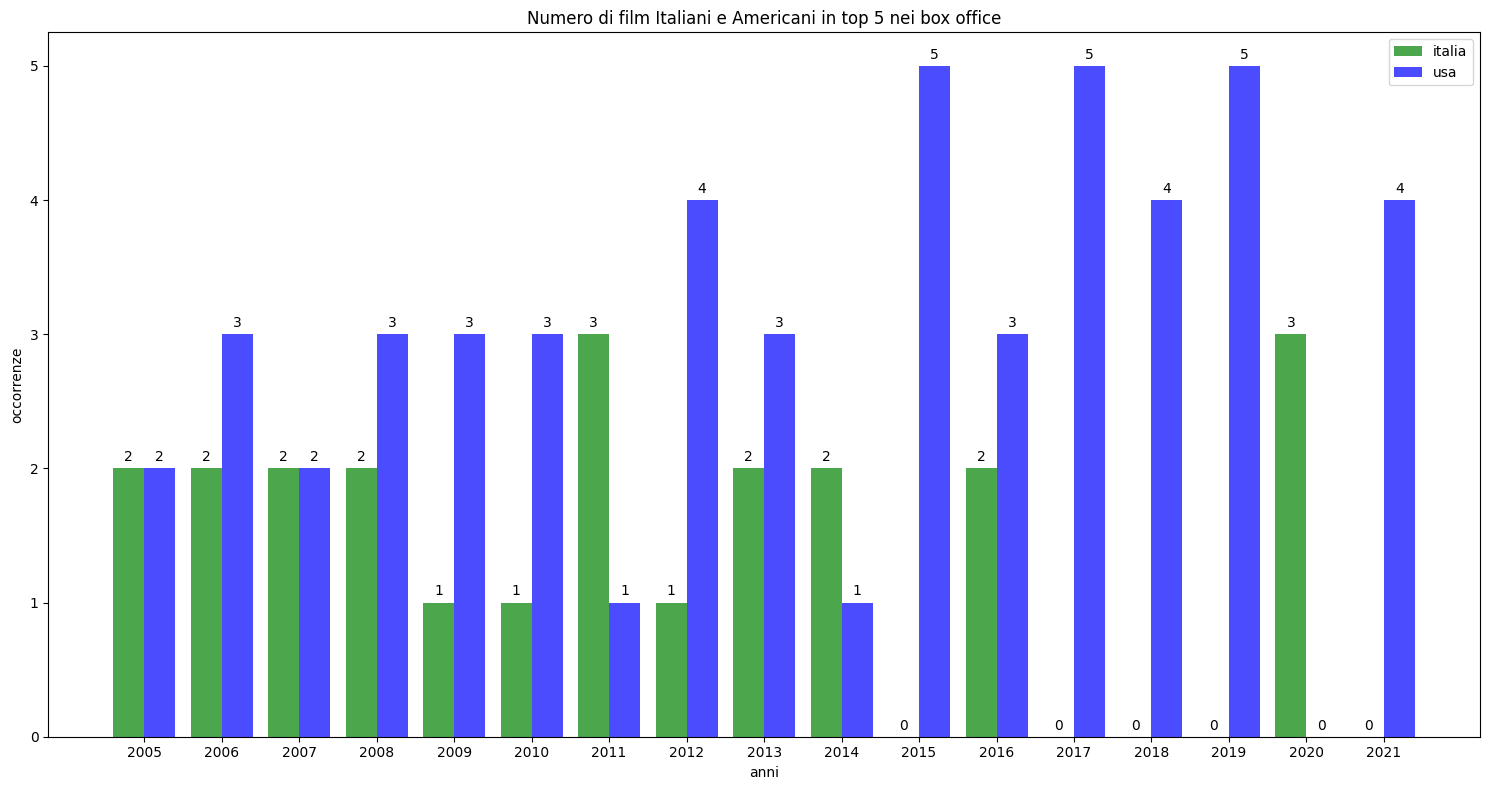

In [101]:
# Film italiani e americani in TOP5

labels = np.arange(2005, 2022)
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(15,8))

width = 0.4

rects1 = ax.bar(x - width/2, itas, width=width, color='green', label='italia', alpha=.7)
rects2 = ax.bar(x + width/2, usas, width=width, color='blue', label='usa', alpha=.7)

ax.set_ylabel('occorrenze')
ax.set_xlabel('anni')
ax.set_title('Numero di film Italiani e Americani in top 5 nei box office')
ax.set_xticks(x, labels)
plt.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.savefig('Dati_Cinema_Italiani/plots/Ita_Usa_occ_top5_groupbarchart.png', bbox_inches='tight')

plt.show()

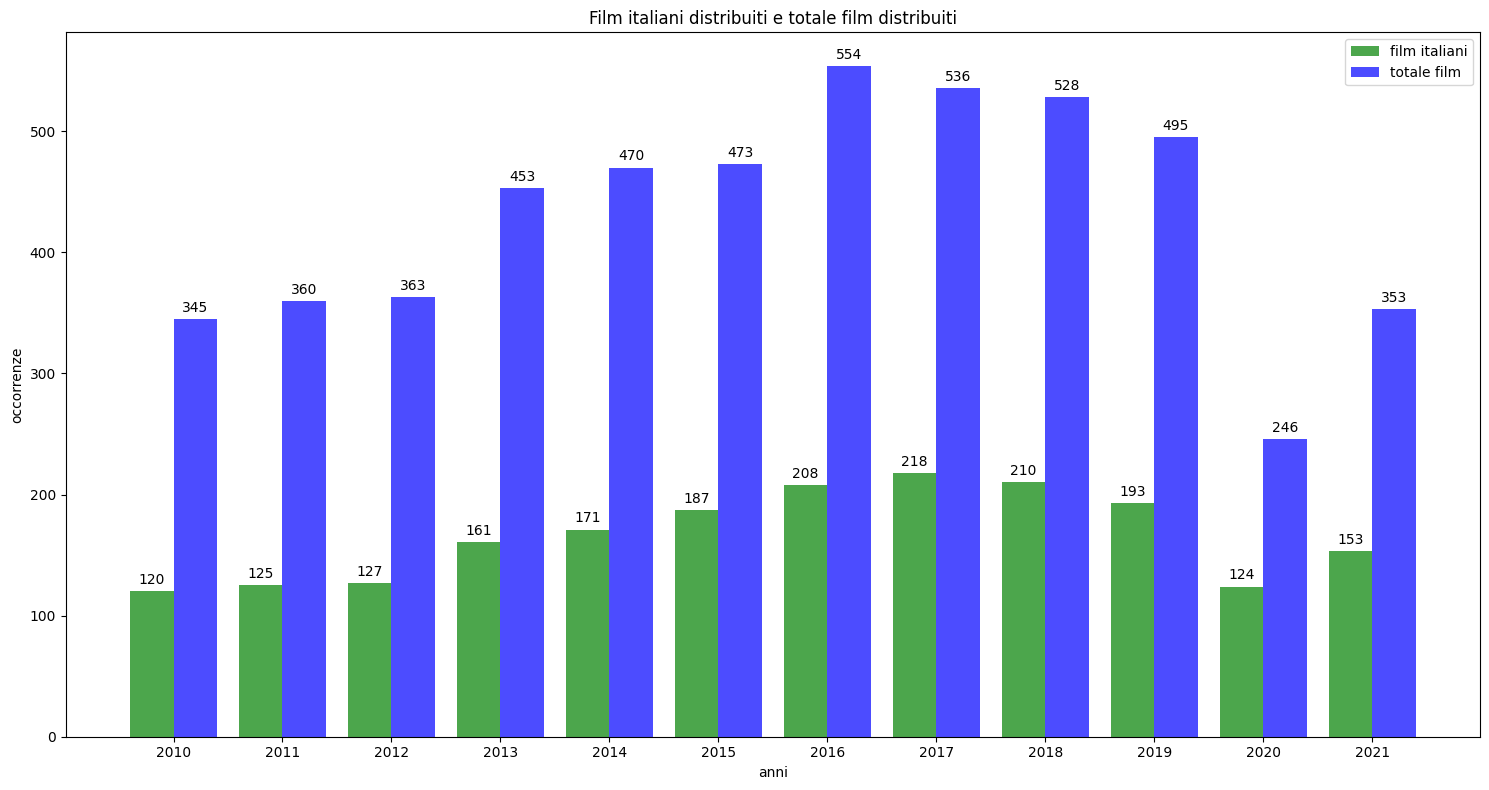

In [99]:
# MA QUANTI NUOVI FILM ITALIANI E NON VENGONO DISTRIBUITI?
# da 2004 a 2009 i dati sono stati predetti con LinearRegression
num_film = pd.read_csv('Dati_Cinema_Italiani/tables/numero_film.csv', sep=',', decimal='.', thousands='.')
num_ita = num_film[num_film['Year'] >= 2010]['Film Italiani co-prodotti']
num_tot = num_film[num_film['Year'] >= 2010]['Totale Film']

labels = np.arange(2010, 2022)
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(15,8))

width = 0.4

rects1 = ax.bar(x - width/2, num_ita, width=width, color='green', label='film italiani', alpha=.7)
rects2 = ax.bar(x + width/2, num_tot, width=width, color='blue', label='totale film', alpha=.7)

ax.set_ylabel('occorrenze')
ax.set_xlabel('anni')
ax.set_title('Film italiani distribuiti e totale film distribuiti')
ax.set_xticks(x, labels)
plt.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.savefig('Dati_Cinema_Italiani/plots/Ita_Usa_occ_top10_groupbarchart.png', bbox_inches='tight')

plt.show()


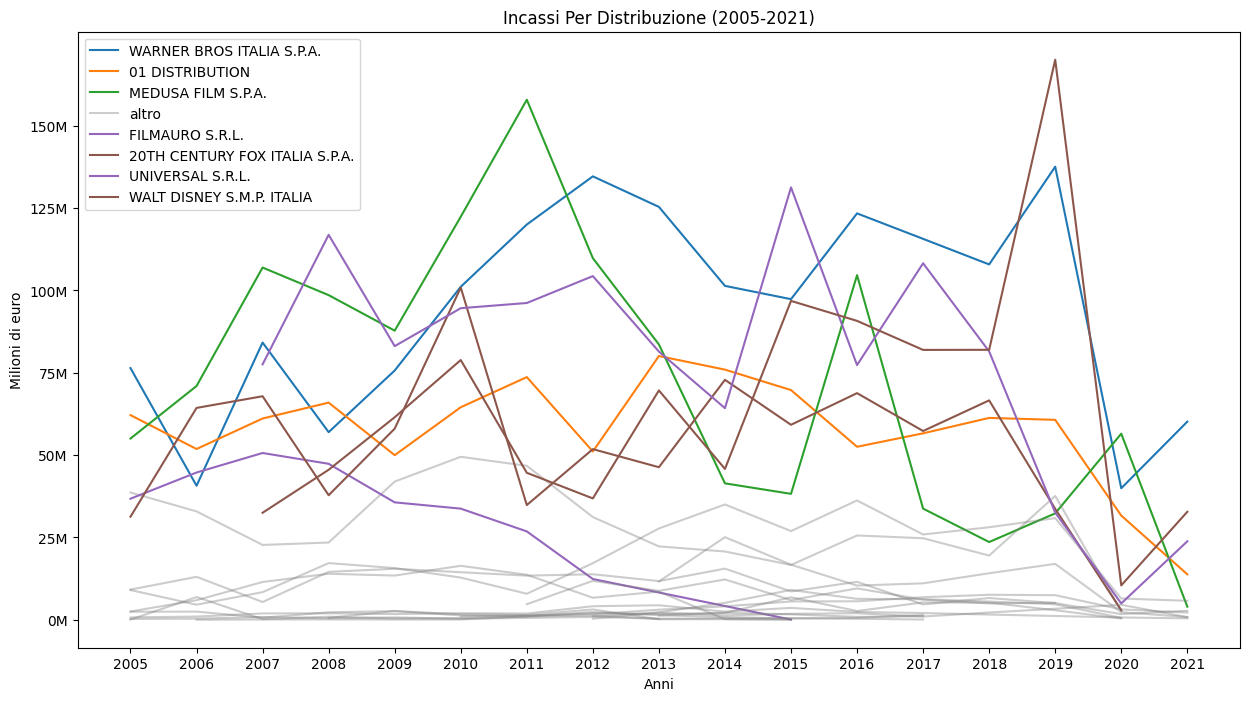

In [12]:
# INCASSI PER DISTRIBUZIONE 2005-2021
# INCASSI FILM IN ITALIA PER NAZIONE

# plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,8))
handles = []

distribuzioni = distr['Distribuzione'].unique()

count = 1;
for d in distribuzioni:
    tmp = distr[distr['Distribuzione'] == str(d)][['Year', 'Incasso']]
    if (len(tmp) < 8):
        continue
    if tmp['Incasso'].max() > 50000000:
        line, = ax.plot(tmp['Year'], tmp['Incasso'], label=d)
        handles.append(line)
    else:
        line, = ax.plot(tmp['Year'], tmp['Incasso'], label='altro', alpha=.4)
        if count == 1: # mi serve per non aggiungere duplicati nella legenda
            handles.append(line)
            count = 0
        line.set_color('grey')

plt.xlabel('Anni')
plt.ylabel('Milioni di euro')
plt.title('Incassi Per Distribuzione (2005-2021)')

ax.legend(handles = handles)

# custom x_ticks for Million
plt.yticks(np.arange(0, distr['Incasso'].max(), step=25000000))
plt.xticks(np.arange(2005, 2022, step=1))
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:1.0f}M'.format(x*0.000_001) for x in current_values])

plt.savefig('Dati_Cinema_Italiani/plots/Incassi_Distribuzioni.png', bbox_inches='tight')

plt.show()